<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/BitCoin_Forecasting_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARMA model and forecast the bit coin price

## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

## Problem Statement

Perform EDA and forecast the Bitcoin price using ARMA model on timeseries (bitcoin) data.

In [ ]:
#@title Download Dataset
!wget -qq !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/BTC.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import itertools

### Load the data and perform EDA [2 points]

Hint: Refer to this ['Bitcoin dataset EDA'](https://medium.com/@hamzaahmad86/exploratory-data-analysis-of-cryptocurrency-historical-data-d8ec719641e7)

In [ ]:
# YOUR CODE HERE
df = pd.read_csv('/content/BTC.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
df[df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
2039,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
2214,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
2217,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
2218,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df['Date']= pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 0 to 2519
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2516 non-null   datetime64[ns]
 1   Open       2516 non-null   float64       
 2   High       2516 non-null   float64       
 3   Low        2516 non-null   float64       
 4   Close      2516 non-null   float64       
 5   Adj Close  2516 non-null   float64       
 6   Volume     2516 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 157.2 KB


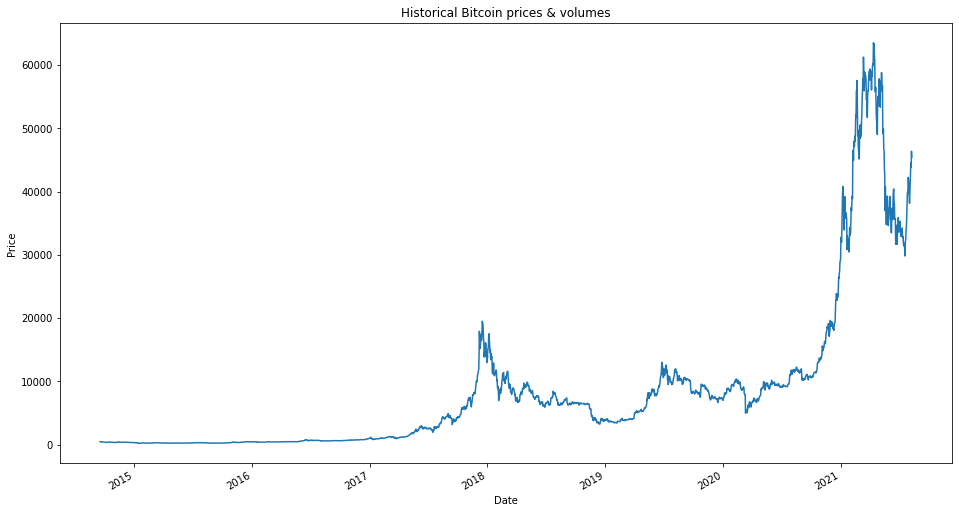

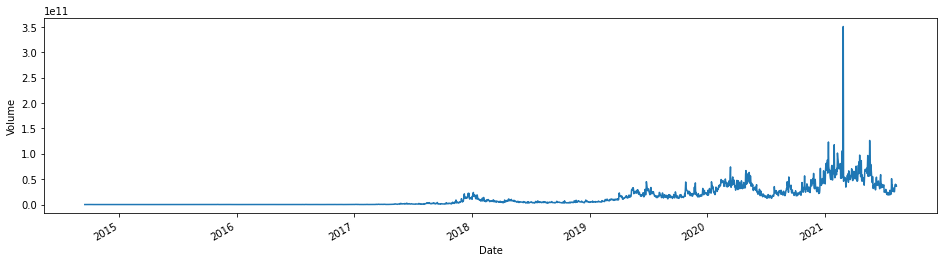

In [ ]:
df.index = df['Date']
df['Adj Close'].plot(figsize=(16, 9))
plt.ylabel('Price')
plt.title('Historical Bitcoin prices & volumes')
plt.show()
df['Volume'].plot(figsize=(16,4))
plt.ylabel('Volume')
plt.show()

In [ ]:
df['year'] = [d.year for d in df['Date']]
df['month'] = [d.strftime('%b') for d in df['Date']]
years = df['year'].unique()

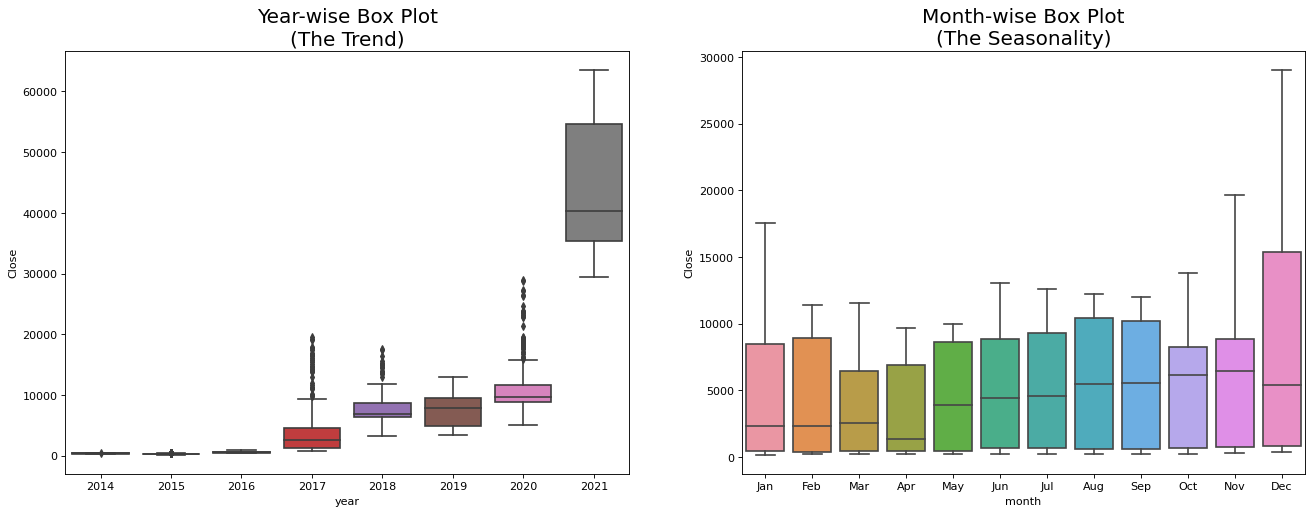

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Close', data=df, ax=axes[0])
sns.boxplot(x='month', y='Close', data=df.loc[~df.year.isin([2014, 2021]), :])

# Set title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

#### Analyze the correlation (heatmap) of all the features

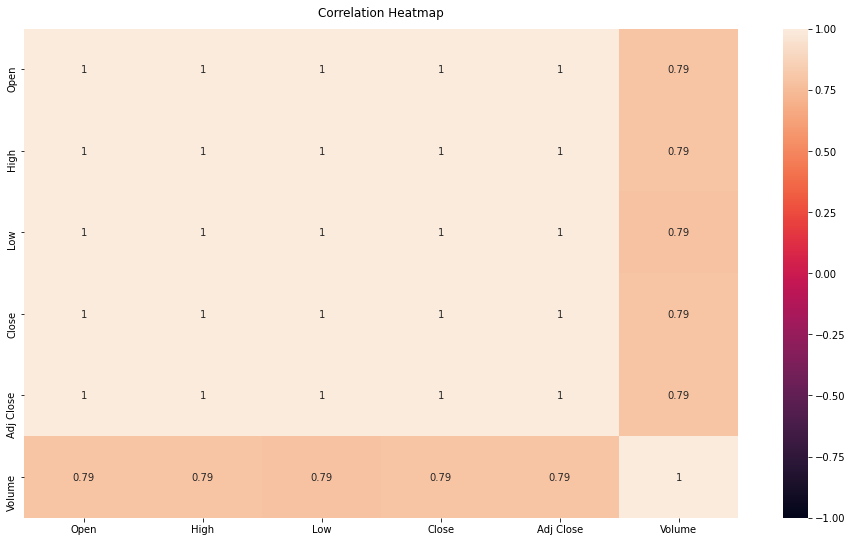

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', pad=12);

[Sathya] Not sure why a correlation heatmap is requested at all. Given the scale of price increase, daily price correlations will be meaningless.

Lag plots are show below instead to detect seasonality.

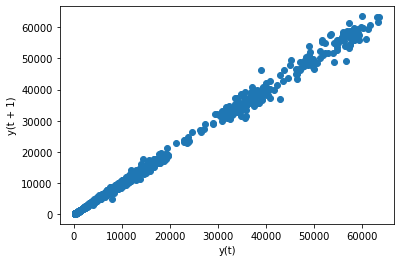

In [ ]:
pd.plotting.lag_plot(df['Close'], lag=1)

We observe there is high correlation between daily Bitcoin prices, which is reasonable as we don't really expect very large movements on daily basis.

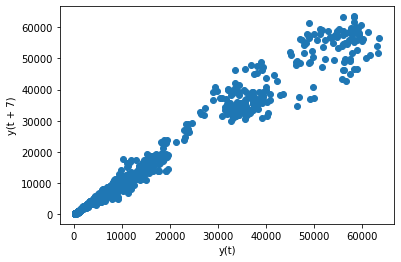

In [ ]:
pd.plotting.lag_plot(df['Close'], lag=7)

We observe there is less correlation between weekly Bitcoin prices, which shows it is a fairly volatile instrument.

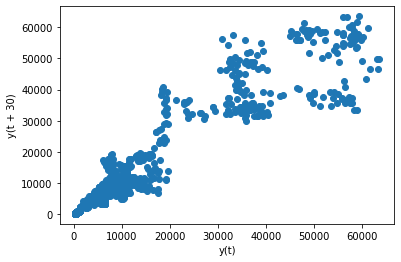

In [ ]:
pd.plotting.lag_plot(df['Close'], lag=30)

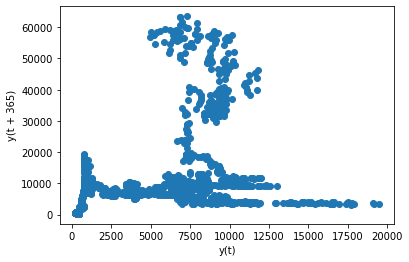

In [ ]:
pd.plotting.lag_plot(df['Close'], lag=365)

As we extend to monthly or annual time periods, we notice there is no correlation in Bitcoin prices at all.

### Test the Stationarity using Augmented Dicky Fuller Test [1 point]

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
# YOUR CODE HERE
adfuller(df['Close'], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-0.03859338766067705,
 0.9552216679751703,
 26,
 2489,
 {'1%': -3.4329799947351503,
  '10%': -2.5673885329713495,
  '5%': -2.862701915447137},
 39186.944347851335)

### Identify the trends and seasonality from the given time series data [2 points]

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing

**Note:** Ensure timeseries without NaN, inf, -inf values, Replace with 0 if found.

Read more about stationarity of a timeseries in the following [link](https://machinelearningmastery.com/time-series-data-stationary-python/)

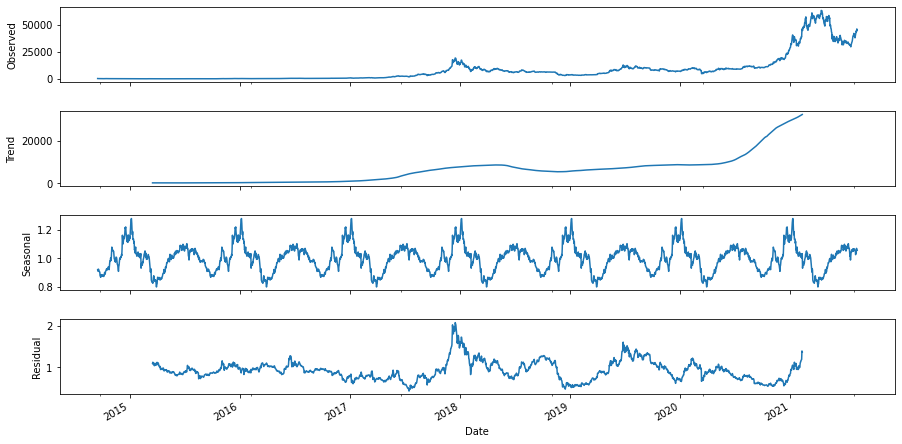

In [ ]:
# YOUR CODE HERE
decomp = seasonal_decompose(df['Close'], model='multiplicative', freq=365)
fig = decomp.plot()
fig.set_size_inches(14,7)

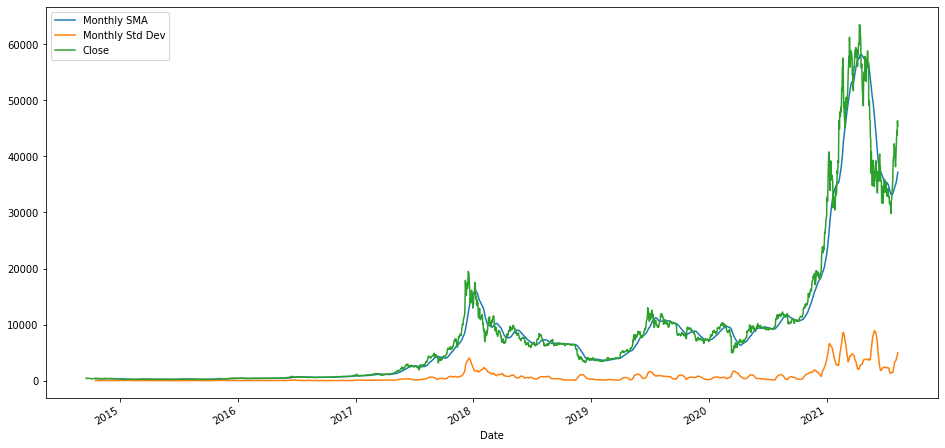

In [ ]:
df['Close'].rolling(30).mean().plot(label='Monthly SMA',figsize=(16,8))
df['Close'].rolling(30).std().plot(label='Monthly Std Dev')
df['Close'].plot()
plt.legend()
plt.show()

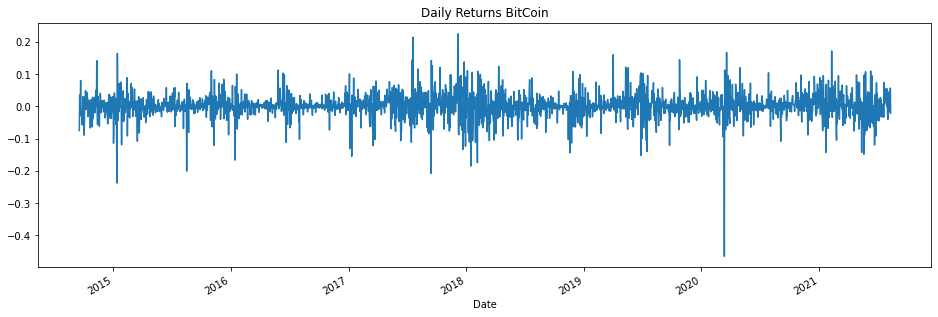

In [ ]:
rs = df['Close'].apply(np.log).diff(1)
rs = rs.dropna()
plt.figure(figsize=(16, 5))
rs.plot(title='Daily Returns BitCoin')

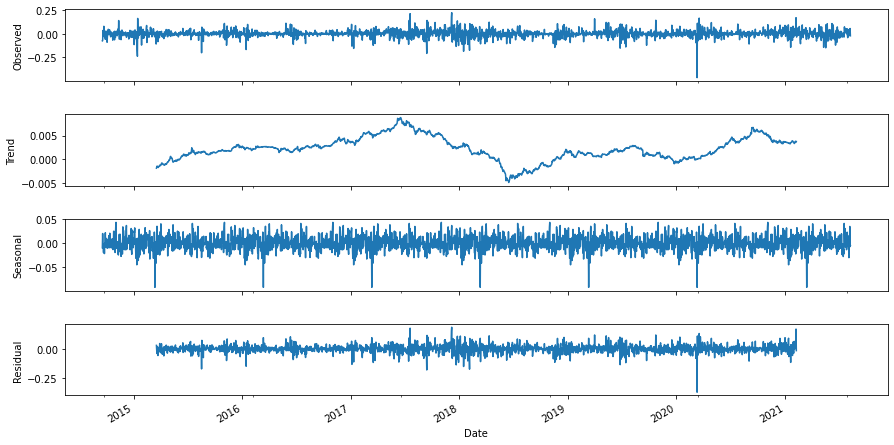

In [ ]:
decomp = seasonal_decompose(rs, model='additive',freq=365)
fig = decomp.plot()
fig.set_size_inches(14,7)

### Test the Stationarity using Augmented Dicky Fuller Test [1 point]

Verify the stationarity post differencing, using ADF

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
# YOUR CODE HERE
adfuller(rs, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-15.051796616333233,
 9.270807363981049e-28,
 9,
 2505,
 {'1%': -3.4329631791044304,
  '10%': -2.5673845793841457,
  '5%': -2.8626944896608433},
 -9011.260123237973)

### Auto Correlation Plot [1 point]

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

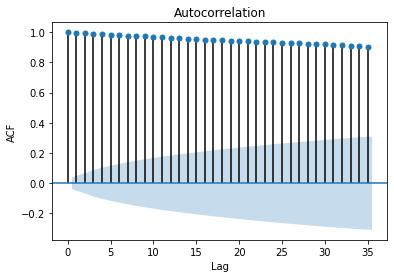

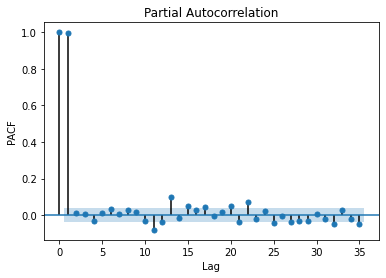

In [ ]:
# YOUR CODE HERE
plot_acf(df['Close'])
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()
plot_pacf(df['Close'])
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.show()